In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from tsmoothie.smoother import *
%matplotlib widget
def setUltrawide():
    #used to run on ultrawide screens
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
#setUltrawide()

In [15]:
fileName = 'ali_test\\test_dataset_7.csv'
#fileName = 'ali_test\\test_data_file_9.csv'
#fileName = 'ali_test\\test_data-file_25a.csv'
df = pd.read_csv(fileName)
dateTimeIndex = False #set true if dataset uses datetime instead of sample data and sample time.
#creates a workable dataframe from the data, so that all function can work with it. 
def createDataFrame(dataframe):
    nullCount = 0 
    for sensorNo in range(8):
        name = 'sensor_' + str(sensorNo+1)
        nullCount = nullCount + (len(df.index) - df[name].count()) #null values are not included in the count functions buy subtracting them with the toal values only null values are present
    
    #create index 
    dataframe.dropna() #all null values are removed 
    
    if(dateTimeIndex):
        dataframe = datetime(dataframe) 
    #only use datetime on specific datasets
    dfindex = []
    for x in range(len(dataframe.index)):
        #formats datetime
        dfindex.append(pd.to_datetime((dataframe['sample_date'][x] +' '+ dataframe['sample_time'][x]), dayfirst= True ))
    dataframe.index = dfindex
    
    #creates index based on datetime
    nullPercentage = (nullCount * 100) / (len(df.index) * 8)
    print('nullValues: ' + str(nullCount))
    print('Null Values Percentage: '+str(nullPercentage))
    print()
    
    return dataframe
df = createDataFrame(df)
findRemoved(420)
#incorrectReadings(10)
#missingValues(30)


nullValues: 0
Null Values Percentage: 0.0

Braclet removed between   2021-12-31 07:35:26  and   2022-01-01 00:04:08.     Total: 988.7 minutes
Bracelet Removed Percentage: 53.28482888709243



In [5]:
#detect when the braclet is removed
#sensor 2 is shown to reach its maximum value whenever the braclet is removed. 
def findRemoved(threshold):
    """
    Parameters:
    Treshold - The minimum amount of mintues to allow the braclet to be removed
    """
    positiveGradThreshold = 200
    negativeGradTheshold = -100
    #check values between these two points. 
    
    startTime = []
    endTime  = []
    overallTotal = 0 
    #fig,ax = plt.subplots()
    sen2Grad = np.gradient(df['sensor_2'])
    index = 0 
    searchForEnding = False #switches between searching for a start point or and end point
    for x in range(len(df['sensor_2'])):
        #find a sudden jump in gradient indicating braclet removed
     
  
        if (((sen2Grad[x]>200) or (df['sensor_2'][x]> 1000) )and (not searchForEnding)):
            #signifies starting time, that braclet is removed
            startTime.append(x)
            searchForEnding = True
            
        elif(searchForEnding and abs(sen2Grad[x]) > 5):
            endTime.append(x)
            searchForEnding = False
            
        elif(searchForEnding and x == len(df['sensor_2'])-1):
            endTime.append(x)
            #looks into case where bracelet is removed but is not put back on before the time ends
    if (len(endTime) == 0):
        #braclet was not removed.
        print("braclet was not removed")
    
    diffArray = []
    if (len(startTime) == len(endTime)):
        for x in range(len(startTime)):
            difference = df.index[endTime[x]] - df.index[startTime[x]] 
            difference = difference.total_seconds()/60
            
            diffArray.append(difference)
            if (difference >= threshold):
                print('Braclet removed between   ' + str(df.index[startTime[x]]) + '  and   ' + str(df.index[endTime[x]]) + '.     Total: ' + str(difference)+ ' minutes')
                overallTotal = difference + overallTotal
            #print(difference)
           # print(str(startTime[x]) + ' ' + str(endTime[x]))
    else:
        print('ERROR: values do not match up. ')
    #ax.plot(df.index,df['sensor_2'])
    #ax.plot(df.index,sen2Grad)
    totalTime = df.index[len(df.index)-1] - df.index[0]
    totalTime = totalTime.total_seconds() /60
    percentage = overallTotal * 100 / totalTime
    print('Bracelet Removed Percentage: ' + str(percentage))
    print()
findRemoved(60)


Braclet removed between   2021-12-29 06:40:01  and   2021-12-29 13:43:25.     Total: 423.4 minutes
Braclet removed between   2021-12-30 01:11:06  and   2021-12-30 07:53:41.     Total: 402.5833333333333 minutes
Braclet removed between   2021-12-31 05:39:34  and   2021-12-31 08:48:56.     Total: 189.36666666666667 minutes
Bracelet Removed Percentage: 18.158379483633286



percentage of incorrect values: 0.0


<AxesSubplot:>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
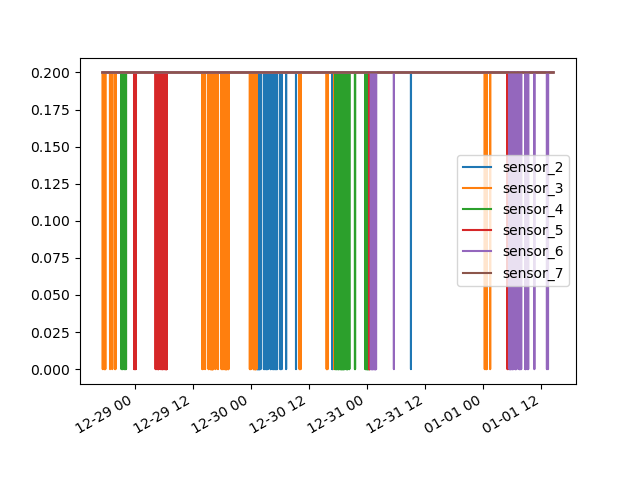

In [6]:
def findIncorrect():
    #not entirely necessary, but useful if double checking for clean data. 
    
    #how close should the values be to each other based on the readings of how to correct values are near each other.
    noiseLevel = 550 #the vlaues of each sensor around this specific zone should be above this value
    maximumThreshold = 1010 #the expected values the focussed sensor should be above. 
    sen7Threshold = 960
    #incorrect values are found by identifying when values are correct. 
    
    sensors = [df['sensor_1'],df['sensor_2'],df['sensor_3'],df['sensor_4'],df['sensor_5'],df['sensor_6'],df['sensor_7'],df['sensor_8']] #sensor values that are able to have their adjacent sensors compared. 

    
    correctValues = pd.DataFrame(index = df.index)
    incorrectValues = pd.DataFrame(index = df.index)
    
    for sensorNo in range(6):
        sensorThreshold = maximumThreshold
        correctArray = []
        incorrectArray = []
  
        #check for specific values
        #method relies on matching gradients instead of finding 
        
        sensor = sensors[sensorNo+1]
        previousSensor = sensors[sensorNo]
        followingSensor = sensors[sensorNo+2]
        
        preGrad = np.gradient(previousSensor)
        followGrad = np.gradient(followingSensor)
        #have to change vlaues when sensor 7 is checked, as its point is lower
        incorrect = 0 
        if(sensorNo+2 ==7):
            
            sensorThreshold = sen7Threshold
        else:
            sensorThreshold = maximumThreshold
        for x in range(len(df.index)):
            if(preGrad[x]<0  and  followGrad[x]> 0  and previousSensor[x] > noiseLevel and followingSensor[x] > noiseLevel):
                #the conditions have now been met to check if the sensor is displaying a correct value. 
                if(sensor[x] > sensorThreshold):
                    correctArray.append(1)
                    incorrectArray.append(0)
                else:
                    correctArray.append(0)
                    incorrectArray.append(1)
                    incorrect = incorrect + 1
            else:
                correctArray.append(0.2)
                incorrectArray.append(0.2)

        name = 'sensor_'+str(sensorNo+2)
        correctValues[name] = correctArray
        incorrectValues[name] = incorrectArray
    
    percentage = (incorrect * 100)/ len(df.index)
    for x in incorrectArray:
        if (x == 1):
            print('meme')
    print('percentage of incorrect values: ' + str(percentage))
    Values = [correctValues,incorrectValues]
    return Values
        
Values = findIncorrect()
#fig, ax = plt.subplots()
Values[1].plot()


In [7]:
def incorrectReadings(diffThreshold):
    """
    Parameters:
    diff threshold - The maximum difference between the adjacents sensors allowed when identifying incorrect readings
    """
    maximumThreshold = 950 #value to check sensor when it reached it max value
    noiseLevel = 550 #values to exclude when comparing the adjacent sensor
    sen7Threshold = 960 #specific threshold for sensor 7 which is lower that the others
    #incorrect values are found by identifying when values are correct. 
    totalPoints = 0 #used to calculate percentage
    indexes = []
    incorrectSensors = {} #dcitionary holding the values of all incorrect sensors
    for sensorNo in range(6):
        sensorThreshold = maximumThreshold
        incorrectCount = 0 #holds how many incorrect values per sensor
        incorrectName = '' #holds name of sensor

        sensor = 'sensor_' + str(sensorNo+2)
        previousSensor = 'sensor_' +str(sensorNo+1)
        followingSensor = 'sensor_' + str(sensorNo+3)
        #names of each sensor
        
        if(sensorNo+2 ==7):
            
            sensorThreshold = sen7Threshold
        else:
            sensorThreshold = maximumThreshold
        #allows a single value to determine the maximum threshold
        
        for x in range(len(df.index)):
            if((abs(df[previousSensor][x] - df[followingSensor][x]) < diffThreshold) and (df[sensor][x]<sensorThreshold)and (df[previousSensor][x]>noiseLevel)):
                #the conditions for an incorrect values have been met
                incorrectCount = incorrectCount + 1
                incorrectName = sensor
                
            
        if(incorrectName != ''):
            incorrectSensors[incorrectName] = incorrectCount
    totalLength = len(df.index) #since data can only be tested for incorrect values one at a time it is compared against the legnth of the index.
    percentage = 0 
    if(len(incorrectSensors) == 0):
        print('All values are correct')
    else: 
        for x in incorrectSensors:
            percentage = percentage + ((incorrectSensors[x]* 100 )/totalLength)
            print('Incorrect reading in: ' + str(x) + ' Percentage:  ' + str((incorrectSensors[x]* 100 )/totalLength))
   
    print('Percentage of total incorrect readings: ' + str(percentage))
    print()
    return 
incorrectReadings(10)

All values are correct
Percentage of total incorrect readings: 0



In [9]:
def missingValues(threshold):
    """
    Parameters:
    Treshold - The amount of minutes allowed before it is flagged as missing
    """
    previousValues = 0
    totalMinutes = 0 
    for x in range(len(df.index)):
        if (x >= 1):
            previousValues = x-1
            dateTimeDiff = df.index[x] - df.index[previousValues]
            minutes = dateTimeDiff.total_seconds() 
            minutes = minutes / 60
            if ( minutes >= threshold):
                #braclet has gone over an the without reading data Values
                print('Gap in data detected, between '+ str(df.index[previousValues]) + ' and '+ str(df.index[x]) + ' Total: '+str(minutes) +'minutes')
                totalMinutes = totalMinutes + minutes
    overallMinutes = df.index[len(df.index)-1] - df.index[0]
    overallMinutes = overallMinutes.total_seconds() / 60
    percentage = totalMinutes * 100 / overallMinutes
    print('Missing Value Percentage: ' + str(percentage))
    print()
missingValues(5)

Gap in data detected, between 2021-12-29 08:54:58 and 2021-12-29 09:00:56 Total: 5.966666666666667minutes
Gap in data detected, between 2021-12-29 14:19:03 and 2021-12-29 14:24:34 Total: 5.516666666666667minutes
Gap in data detected, between 2021-12-29 20:27:09 and 2021-12-29 20:40:04 Total: 12.916666666666666minutes
Gap in data detected, between 2021-12-29 20:30:15 and 2021-12-29 20:46:16 Total: 16.016666666666666minutes
Gap in data detected, between 2021-12-29 20:30:46 and 2021-12-29 20:39:33 Total: 8.783333333333333minutes
Gap in data detected, between 2021-12-29 20:33:21 and 2021-12-29 20:43:10 Total: 9.816666666666666minutes
Gap in data detected, between 2021-12-30 01:30:12 and 2021-12-30 01:43:07 Total: 12.916666666666666minutes
Gap in data detected, between 2021-12-30 10:16:25 and 2021-12-30 15:35:22 Total: 318.95minutes
Gap in data detected, between 2021-12-30 21:40:44 and 2021-12-30 21:47:28 Total: 6.733333333333333minutes
Gap in data detected, between 2021-12-30 23:21:59 and 

In [10]:
def datetime(dataframe): 
    dataframecopy = dataframe
    date = []
    time = []
    for x in dataframecopy['DateTime']:
        
        date.append(x.split(' ')[0][0:4] +'/'+ x.split(' ')[0][4:6] +'/'+ x.split(' ')[0][6:8])
        time.append(x.split(' ')[1])
    dataframe['sample_date'] = date
    dataframe['sample_time'] = time
    return dataframe

129
139
140
141
151
152
162


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sample_date,sample_time,dist
2021-12-03 16:07:13,683,1020,545,502,503,506,507,506,03/12/2021,16:07:13,0.0425
2021-12-03 16:07:14,683,1020,545,502,503,506,507,506,03/12/2021,16:07:14,0.0425
2021-12-03 16:07:16,683,1020,545,502,503,506,507,506,03/12/2021,16:07:16,0.0425
2021-12-03 16:07:17,683,1020,545,502,503,506,507,506,03/12/2021,16:07:17,0.0425
2021-12-03 16:07:19,683,1020,545,502,503,506,507,506,03/12/2021,16:07:19,0.0425
